In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import jaxquantum.codes as jqtb
from jax import jit, grad
import jax.numpy as jnp
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools

In [3]:
def MX_plus():

    g = jqt.basis(2,0)
    e = jqt.basis(2,1)
    plus = (g + e).unit()
    pp = plus @ plus.dag()
    kmap = jqt.QarrayArray.create([2*pp])

    return jqtc.Gate.create(
        2, 
        name="MXplus",
        gen_KM = lambda params: kmap,
        num_modes=1
    )

In [4]:
def run_circuit(params):
    gammas_x = 2*jnp.pi*params[0]
    gammas_y = 2*jnp.pi*params[1]
    betas = params[2]
    
    N = 30
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    for i in range(len(gammas_x)):
        cirq.append(jqtc.Rx(gammas_x[i]), 0)
        cirq.append(jqtc.Ry(gammas_y[i]), 0)
        cirq.append(jqtc.CD(N, betas[i]), [0, 1])
    
    cirq.append(MX_plus(), 0)

    initial_state = jqt.ket2dm(jqt.basis(2,0) ^ jqt.basis(N,0))
    res = jqtc.simulate(cirq, initial_state, mode="kraus")

    return res[-1][-1].unit()

Text(62.44444444444453, 0.5, 'Im[α]')

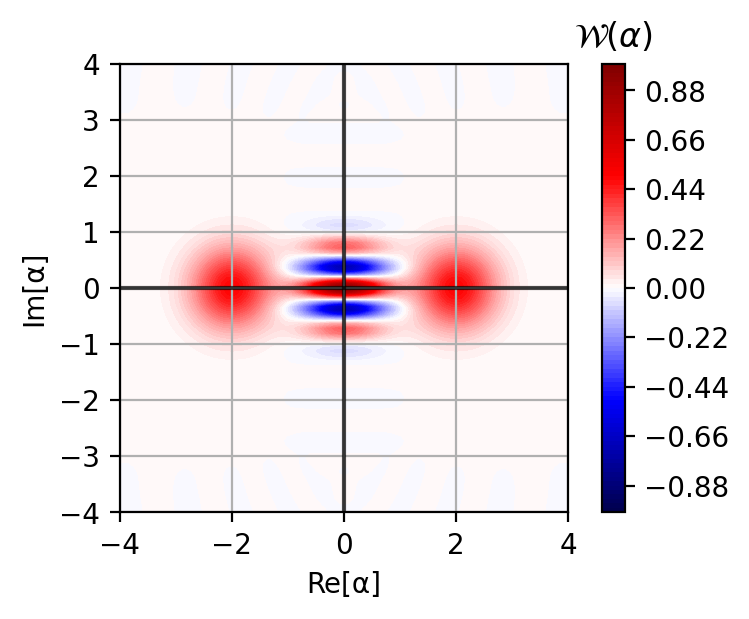

In [5]:
params = jnp.array([[0.0,0.0], [0.25,0.0], [4,0.0]])

final_state = run_circuit(
    params
)

state = final_state
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

Text(62.44444444444453, 0.5, 'Im[α]')

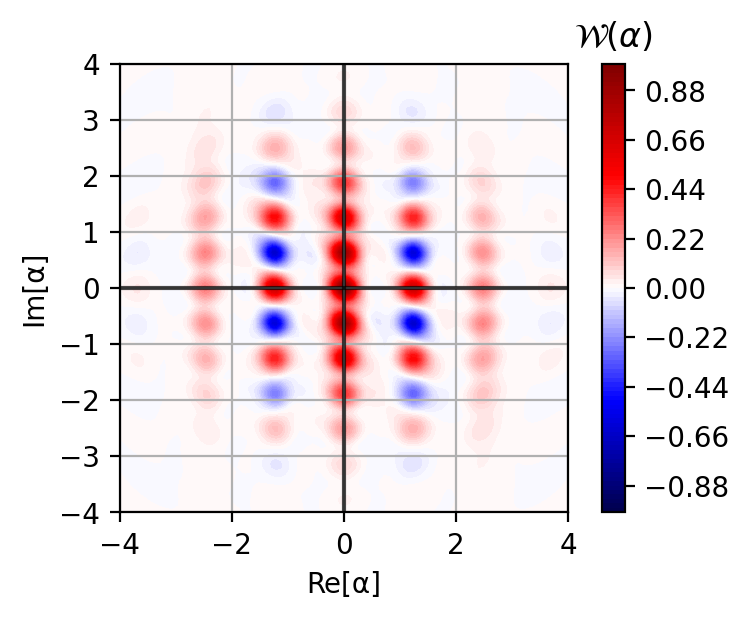

In [6]:
gkp_qubit = jqtb.GKPQubit({"delta": 0.3, "N": 30})
target_state = gkp_qubit.basis["+z"]
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state, pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

In [7]:
def fid_metric(params):
    N = 30
    prepared_state = jqt.ptrace(run_circuit(params),1)
    return jnp.real(jqt.overlap(target_state, prepared_state).data[0][0])

fid_metric_vmap = jax.vmap(fid_metric, in_axes=(0,))

def metric(params):
    fids = fid_metric_vmap(params)
    losses = jnp.log(1 - fids)
    avg_loss = jnp.average(losses)
    return avg_loss

metric(jnp.array([params,2*params]))

Array(-0.08402273, dtype=float64)

# Batch Gradient Descent

In [8]:
# Functions
metric_val_and_grad = jit(jax.value_and_grad(metric))
fid_metric_vmap_jit = jit(fid_metric_vmap)

# Parameters
key = jax.random.PRNGKey(0)  # Initialize a random key
B = 100 # Batch size
num_blocks = 6
lower_bounds = jnp.array([-1, -1, -20])  # Define the lower bounds for each axis
upper_bounds = jnp.array([1, 1, 20])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 3, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params)
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params)

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params)
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params)

1min 34s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
28.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.32 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
start_learning_rate = 1e-2
optimizer = optax.adam(start_learning_rate)
params = random_initial_params
opt_state = optimizer.init(params)

# A simple update loop.
params_history = []
fids_history = []
metric_history = []

epochs = 200
for j in tqdm(range(epochs)):
  params_history.append(params)
  fids_history.append(fid_metric_vmap_jit(params))
  metric, grads = metric_val_and_grad(params)
  metric_history.append(metric)

  if j % 10 == 0:
    print(f"Epoch {j}: metric = {metric:.4f}, best fid = {jnp.max(fids_history[-1])}")

  if j < epochs - 1:
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

params_history = jnp.array(params_history)
fids_history = jnp.array(fids_history)
metric_history = jnp.array(metric_history)

  0%|          | 1/200 [00:06<21:50,  6.58s/it]

Epoch 0: metric = -0.0792, best fid = 0.26519528783086127


  6%|▌         | 11/200 [01:14<20:01,  6.36s/it]

Epoch 10: metric = -0.3684, best fid = 0.46042983860050113


 10%|█         | 21/200 [02:16<18:28,  6.19s/it]

Epoch 20: metric = -0.5287, best fid = 0.5601320921335892


 16%|█▌        | 31/200 [03:27<20:57,  7.44s/it]

Epoch 30: metric = -0.6571, best fid = 0.6606907175573598


 20%|██        | 41/200 [04:32<16:46,  6.33s/it]

Epoch 40: metric = -0.7623, best fid = 0.7152268367357677


 26%|██▌       | 51/200 [05:35<15:43,  6.33s/it]

Epoch 50: metric = -0.8584, best fid = 0.7556966091566485


 30%|███       | 61/200 [06:36<13:58,  6.03s/it]

Epoch 60: metric = -0.9542, best fid = 0.7761470660190083


 36%|███▌      | 71/200 [07:39<13:43,  6.38s/it]

Epoch 70: metric = -1.0355, best fid = 0.7916877421172664


 40%|████      | 81/200 [08:45<12:30,  6.31s/it]

Epoch 80: metric = -1.1061, best fid = 0.8015383413841948


 46%|████▌     | 91/200 [09:50<11:33,  6.36s/it]

Epoch 90: metric = -1.1608, best fid = 0.8084020258703972


 50%|█████     | 101/200 [10:52<10:13,  6.20s/it]

Epoch 100: metric = -1.2091, best fid = 0.8124175688041055


 56%|█████▌    | 111/200 [11:55<09:20,  6.30s/it]

Epoch 110: metric = -1.2519, best fid = 0.8144415232533802


 60%|██████    | 121/200 [12:59<09:10,  6.97s/it]

Epoch 120: metric = -1.2841, best fid = 0.814403466722457


 66%|██████▌   | 131/200 [14:09<07:15,  6.31s/it]

Epoch 130: metric = -1.3143, best fid = 0.8163855685387179


 70%|███████   | 141/200 [15:11<06:05,  6.20s/it]

Epoch 140: metric = -1.3311, best fid = 0.8181856912404069


 76%|███████▌  | 151/200 [16:22<05:50,  7.15s/it]

Epoch 150: metric = -1.3473, best fid = 0.8215035820612275


 80%|████████  | 161/200 [17:26<04:05,  6.31s/it]

Epoch 160: metric = -1.3653, best fid = 0.81733040523466


 86%|████████▌ | 171/200 [18:43<03:43,  7.70s/it]

Epoch 170: metric = -1.3814, best fid = 0.8230366086988797


 90%|█████████ | 181/200 [19:48<02:04,  6.55s/it]

Epoch 180: metric = -1.3970, best fid = 0.8274443064514441


 96%|█████████▌| 191/200 [20:50<00:55,  6.12s/it]

Epoch 190: metric = -1.4042, best fid = 0.8250583000720696


100%|██████████| 200/200 [21:51<00:00,  6.56s/it]


In [10]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]

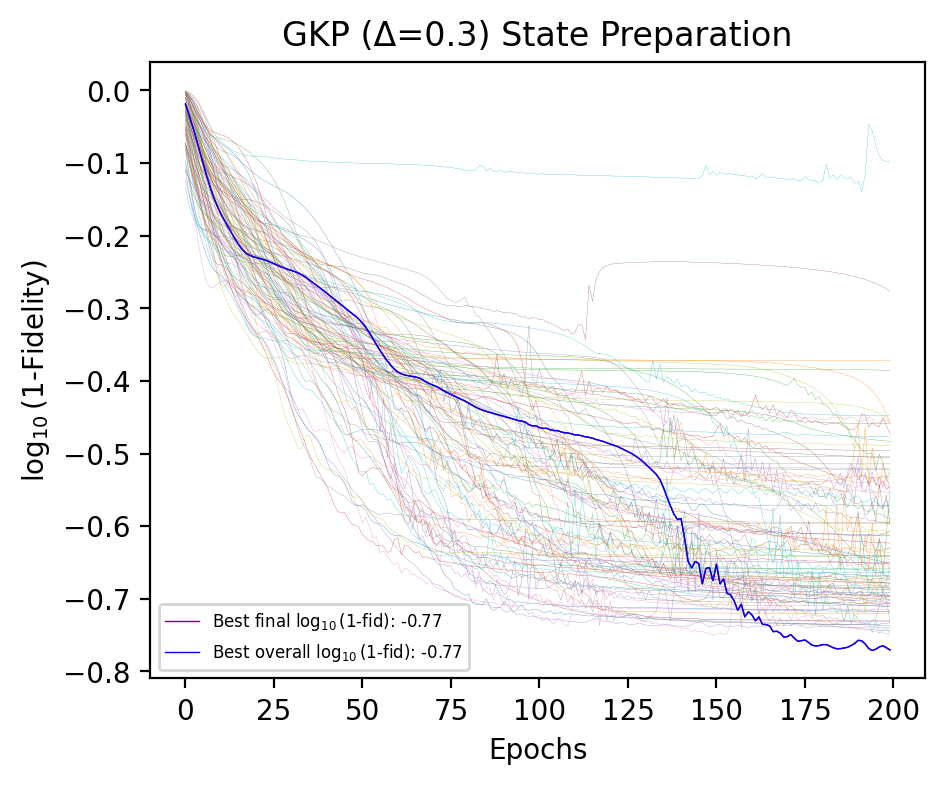

In [11]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)

In [16]:
20*jnp.log10(jnp.exp(jnp.abs(jnp.log(0.35))))

Array(9.11863911, dtype=float64)

Best parameters: 
 [[  1.29654767  -0.02631575   0.9328079    0.64100358   0.32209261
    1.17535681]
 [ -0.30982472  -0.89891196  -0.35070324   1.35510759  -0.41687778
    0.53733576]
 [-11.80348224  -9.35080562   8.44182413  18.20238833  18.4568713
    4.78363516]]


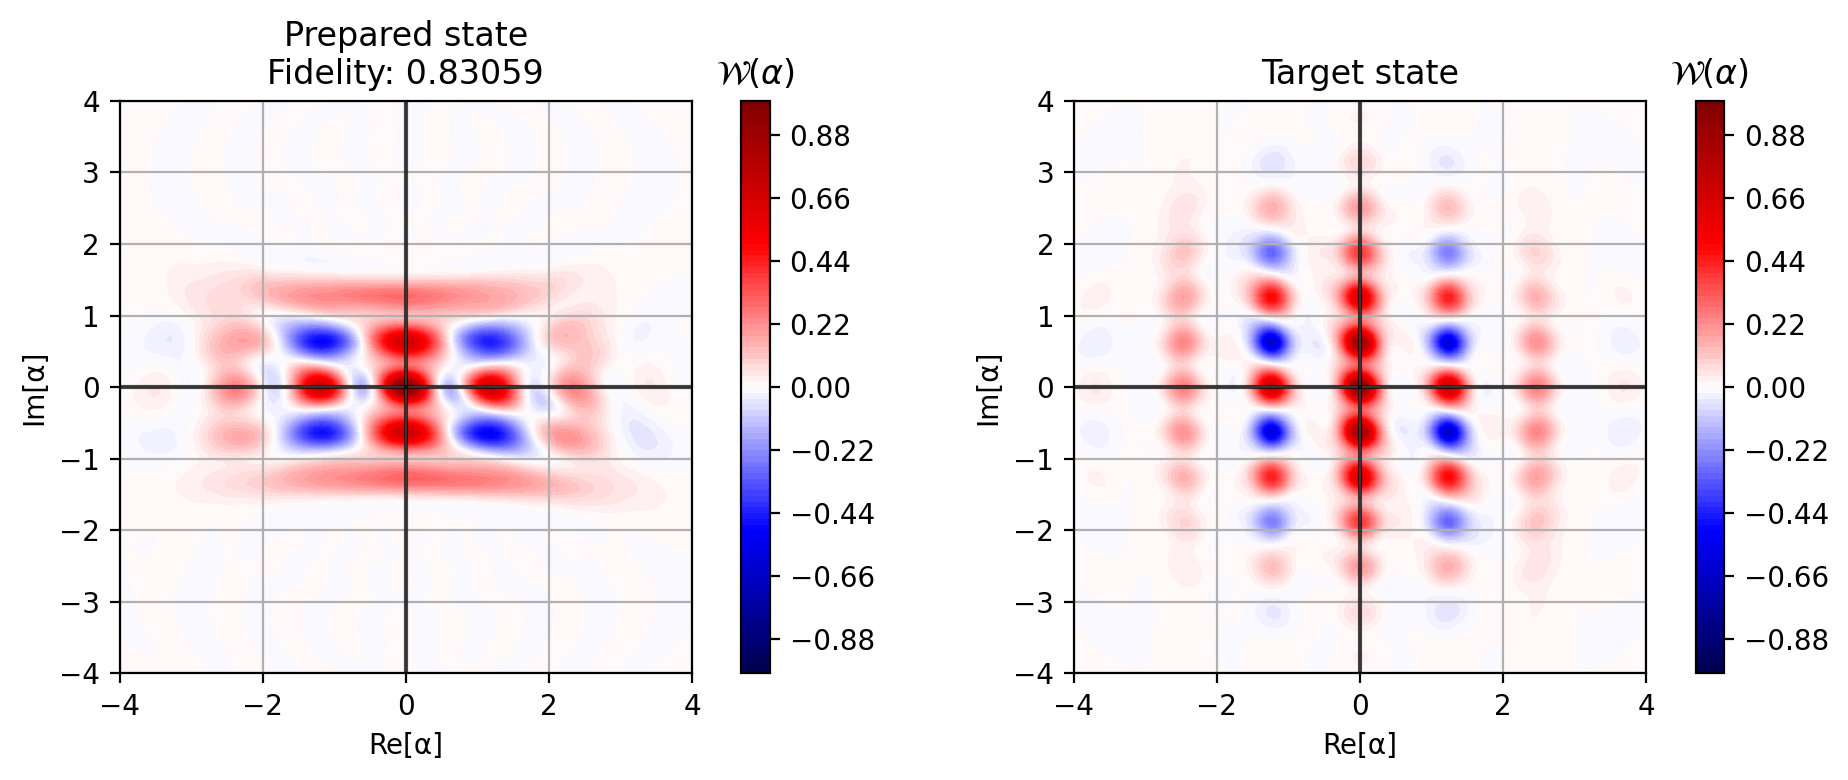

In [12]:
best_params = params_history[best_fid_epoch_indx, best_fid_batch_indx]
print("Best parameters: \n", best_params)


fig,axs = plt.subplots(1,2, dpi=200, figsize=(10,4))

state = run_circuit(best_params)
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts, ax=axs[0])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Prepared state\n" + f"Fidelity: {best_fid:.5f}")


pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state, pts, ax=axs[1])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Target state")

fig.tight_layout()

Array(0.3, dtype=float64, weak_type=True)